In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the preprocessed weather data from the CSV file
df = pd.read_csv("processed_weather_data_6years_3targets.csv")

# Features (X) and multiple target variables (y)
x = df[['temp', 'pressure', 'humidity', 'clouds', 'wind_speed', 'wind_deg', 
        'temp_lag_1', 'pressure_lag_1', 'humidity_lag_1', 'clouds_lag_1', 
        'wind_speed_lag_1', 'wind_deg_lag_1', 'rolling_avg_3hr', 'temp_rolling_avg', 
        'humidity_rolling_avg', 'wind_speed_rolling_avg', 'hour_of_day', 'day_of_week', 
        'is_weekend', 'is_morning', 'is_afternoon', 'is_evening', 'is_night', 'elapsed_time_of_day', 
        'month_of_year', 'day_of_year', 'hourly_avg_temp', 'hourly_temp_max', 'hourly_temp_min']].values

y = df[['target1_temp', 'target1_pressure', 'target1_humidity', 'target1_clouds', 
        'target1_wind_speed', 'target1_wind_deg', 'target2_temp', 'target2_pressure',
        'target2_humidity', 'target2_clouds', 'target2_wind_speed', 'target2_wind_deg', 
        'target3_temp', 'target3_pressure', 'target3_humidity', 'target3_clouds', 
        'target3_wind_speed', 'target3_wind_deg']].values


In [3]:
# Normalize the data (important for neural networks)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [4]:
import joblib

# 3. Save the scalers after fitting them
joblib.dump(scaler_X, 'scaler2_X.pkl')  # Save feature scaler
joblib.dump(scaler_y, 'scaler2_y.pkl')  # Save target scaler

['scaler2_y.pkl']

In [5]:
# Split the data chronologically - 80% past (training) and 20% future (testing)
train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [6]:
# Reshape the data to be 3D (samples, time steps, features) for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [9]:
# Initialize the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(50))
model.add(Dense(18))  # Number of output features (18 targets)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5927 - val_loss: 0.5181
Epoch 2/20
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5007 - val_loss: 0.5060
Epoch 3/20
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4935 - val_loss: 0.5125
Epoch 4/20
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4870 - val_loss: 0.5138
Epoch 5/20
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4823 - val_loss: 0.5191
Epoch 6/20
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4806 - val_loss: 0.5175
Epoch 7/20
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4775 - val_loss: 0.5197
Epoch 8/20
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4746 - val_loss: 0.5235
Epoch 9/20
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4734 - val_loss: 0.5274
Epoch 10/20
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4722 - val_loss: 0.5290
Epoch 11/20
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4674 - val_loss: 0.5197
Epoch 12/20
1317/1317 ━━━━━━━━

In [11]:
# Make predictions on the test set
y_pred_scaled = model.predict(X_test)

330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step


In [12]:
# Inverse transform the scaled predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

In [13]:
# Evaluate the model for each target variable
mse = mean_squared_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

In [14]:
# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 2133.7806825513026
R² Score: 0.46128340781877863


In [15]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Initialize the model
model2 = Sequential()
model2.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))  # Adding Dropout layer for regularization
model2.add(LSTM(50, activation='relu'))
model2.add(Dense(50))
model2.add(Dense(18))  # Number of output features (18 targets)

# Compile the model with Adam optimizer and smaller learning rate
optimizer2 = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer2, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


659/659 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8908 - val_loss: 0.6273
Epoch 2/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6159 - val_loss: 0.5701
Epoch 3/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5721 - val_loss: 0.5551
Epoch 4/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5529 - val_loss: 0.5468
Epoch 5/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5520 - val_loss: 0.5398
Epoch 6/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5408 - val_loss: 0.5357
Epoch 7/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5370 - val_loss: 0.5316
Epoch 8/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5357 - val_loss: 0.5305
Epoch 9/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5325 - val_loss: 0.5275
Epoch 10/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5287 - val_loss: 0.5261
Epoch 11/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5278 - val_loss: 0.5248
Epoch 12/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

In [16]:
# Evaluate the model
y_pred2 = model2.predict(X_test)

330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [17]:
# Inverse transform the scaled predictions and actual values
y_pred2 = scaler_y.inverse_transform(y_pred2)
y_test_actual = scaler_y.inverse_transform(y_test)

In [19]:
# Evaluate the model for each target variable
mse = mean_squared_error(y_test_actual, y_pred2)
r2 = r2_score(y_test_actual, y_pred2)

# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 1942.0670893413107
R² Score: 0.49441467283325796


In [20]:
# Save the current model
model.save('weather_forecast_model_3targets_v2.keras')

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Initialize the LSTM model
model3 = Sequential()

# Add LSTM layer
model3.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

# Add Dropout layer for regularization
model3.add(Dropout(0.2))  # Drop 20% of the neurons

# Add Dense layers
model3.add(Dense(50, activation='relu'))  # Optional: you can experiment with 32, 64, etc.

# Output layer for multiple targets
model3.add(Dense(18))  # Output layer with 18 units for your 18 targets

# Compile the model with a smaller learning rate
optimizer3 = Adam(learning_rate=0.0001)
model3.compile(optimizer=optimizer3, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model3.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Summary of the model architecture
model3.summary()

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8995 - val_loss: 0.6219
Epoch 2/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6059 - val_loss: 0.5600
Epoch 3/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5579 - val_loss: 0.5418
Epoch 4/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5409 - val_loss: 0.5345
Epoch 5/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5326 - val_loss: 0.5299
Epoch 6/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5294 - val_loss: 0.5283
Epoch 7/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5270 - val_loss: 0.5243
Epoch 8/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5246 - val_loss: 0.5236
Epoch 9/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5213 - val_loss: 0.5229
Epoch 10/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5185 - val_loss: 0.5213
Epoch 11/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5196 - val_loss: 0.5194
Epoch 12/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,698 (330.86 KB)

 Trainable params: 28,232 (110.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 56,466 (220.57 KB)

In [22]:
# Evaluate the model
y_pred3 = model3.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred3 = scaler_y.inverse_transform(y_pred3)
y_test_actual = scaler_y.inverse_transform(y_test)

330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step


In [23]:
# Evaluate the model for each target variable
mse = mean_squared_error(y_test_actual, y_pred3)
r2 = r2_score(y_test_actual, y_pred3)

# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 1943.8382232863255
R² Score: 0.49830383048032445


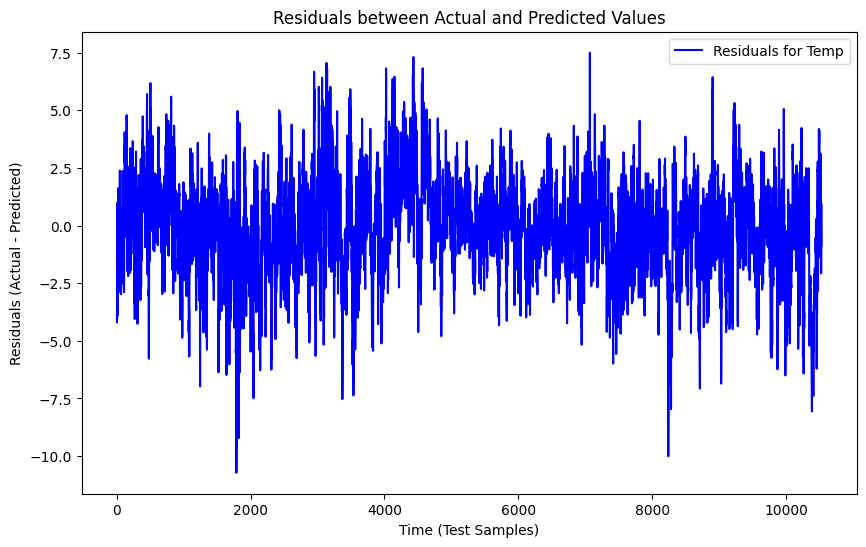

In [24]:
import matplotlib.pyplot as plt

# Calculate the residuals (differences between actual and predicted values)
residuals = y_test_actual - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals[:, 0], label="Residuals for Temp", color='blue')
plt.title("Residuals between Actual and Predicted Values")
plt.xlabel("Time (Test Samples)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.show()

In [25]:
# Save the current model
model.save('weather_forecast_model_3targets_v3.keras')